In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

import pmdarima as pm
from pmdarima.model_selection import train_test_split
from statsmodels.stats.diagnostic import acorr_ljungbox

import warnings
warnings.filterwarnings('ignore')

In [44]:
df=pd.read_csv("prices-split-adjusted.csv", index_col=0)
apple = df[df['symbol'] == 'AAPL']

In [45]:
apple.head()

,symbol,open,close,low,high,volume
date,,,,,,
2010-01-04,AAPL,30.490000,30.572857,30.340000,30.642857,123432400.0
2010-01-05,AAPL,30.657143,30.625713,30.464285,30.798571,150476200.0
2010-01-06,AAPL,30.625713,30.138571,30.107143,30.747143,138040000.0
2010-01-07,AAPL,30.250000,30.082857,29.864286,30.285715,119282800.0
2010-01-08,AAPL,30.042856,30.282858,29.865715,30.285715,111902700.0


In [46]:
apple.index.sort_values()

Index(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07', '2010-01-08',
       '2010-01-11', '2010-01-12', '2010-01-13', '2010-01-14', '2010-01-15',
       ...
       '2016-12-16', '2016-12-19', '2016-12-20', '2016-12-21', '2016-12-22',
       '2016-12-23', '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30'],
      dtype='object', name='date', length=1762)

In [47]:
# Convert index to pandas datetime
apple.index = pd.to_datetime(apple.index, format="%Y-%m-%d")

In [48]:
# drop all columns except for close price
apple = apple[['close']]
apple.head()

,close
date,
2010-01-04,30.572857
2010-01-05,30.625713
2010-01-06,30.138571
2010-01-07,30.082857
2010-01-08,30.282858


In [49]:
apple.isna().sum()

close    0
dtype: int64

Text(0.5, 1.0, 'Time Series Plot')

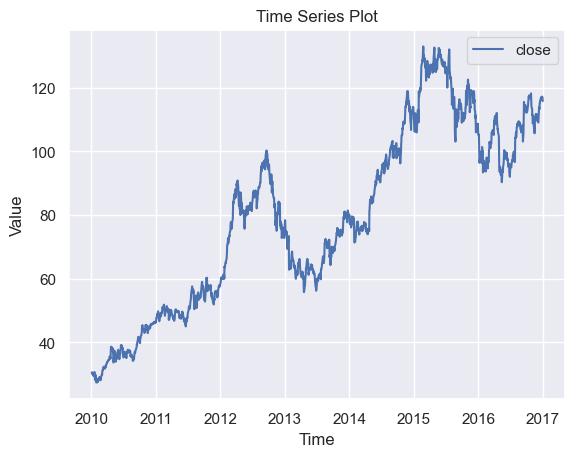

In [50]:
sns.set(style="darkgrid")  # Set a style for the plot
sns.lineplot(data=apple)

# Set labels and title
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Time Series Plot")

In [51]:
kpss(apple, regression='c')

(5.4509082952026215,
 0.01,
 26,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [52]:
kpss(apple.fillna(0), regression='ct')

(0.3051050718910746,
 0.01,
 26,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

In [53]:
apple.diff().isna().sum()

close    1
dtype: int64

Text(0.5, 1.0, 'Diffferecing')

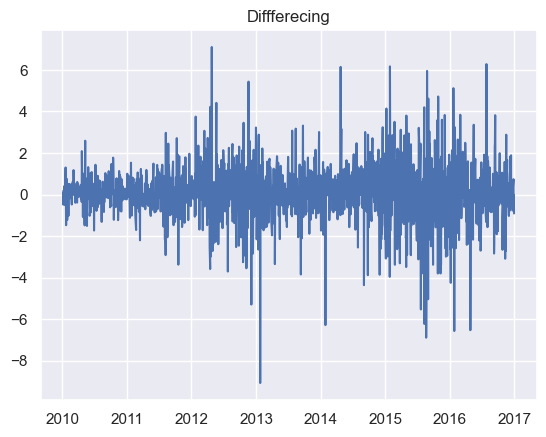

In [54]:
# differencing close price twice
apple_diff=apple.diff()
apple_diff.dropna(inplace=True)
plt.plot(apple_diff)
plt.title('Diffferecing')

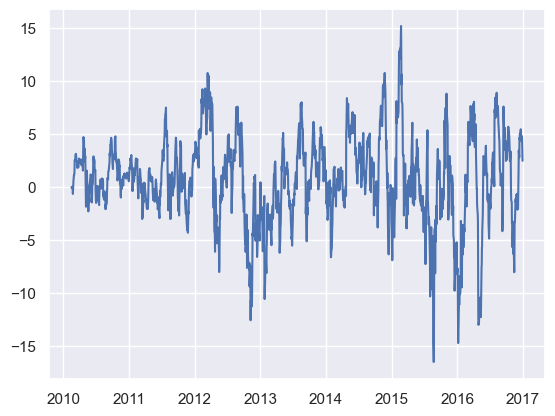

In [55]:
# detrending close price
apple_detrend = apple - apple.rolling(window=30).mean()
apple_detrend.dropna(inplace=True)
# plot_acf(apple_detrend, lags=12)
# plot_pacf(apple_detrend, lags=12)
plt.plot(apple_detrend)

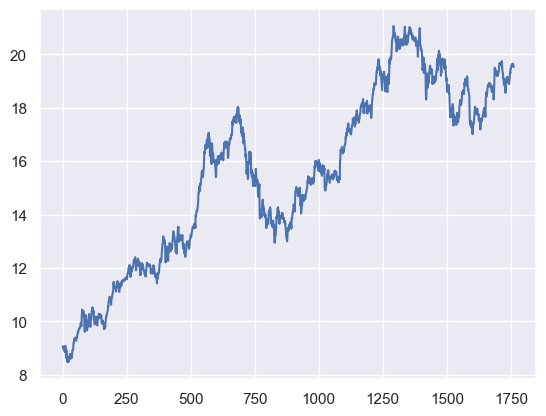

In [56]:
# boxcox transformation close price
from scipy.stats import boxcox

apple_boxcox = boxcox(apple['close'], lmbda=0.5)
plt.plot(apple_boxcox)

In [57]:
kpss(apple_diff, regression='c')

(0.06697633741149607,
 0.1,
 9,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

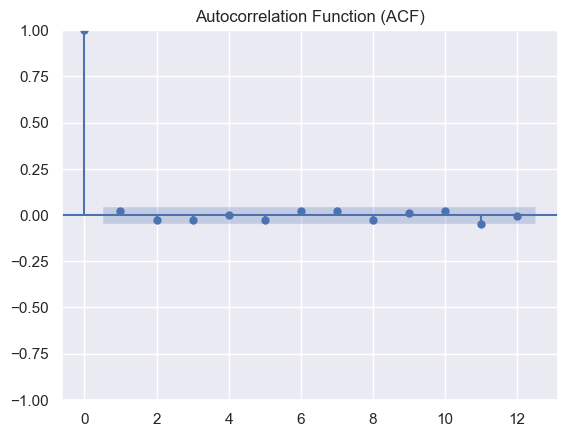

In [58]:
# Create ACF plot
plot_acf(apple_diff, lags=12)  # 'lags' specifies the number of lags to include in the plot
plt.title('Autocorrelation Function (ACF)')
plt.show()

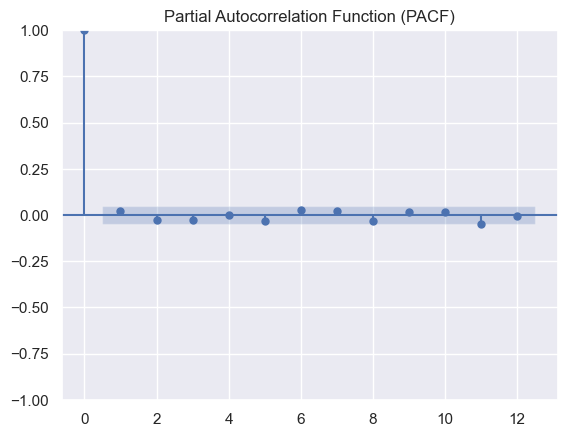

In [59]:
# Create PACF plot
plot_pacf(apple_diff, lags=12)  # 'lags' specifies the number of lags to include in the plot
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [60]:
len(apple)
1762*0.7

1233.3999999999999

In [61]:
train, test = train_test_split(apple_diff, train_size=1234)

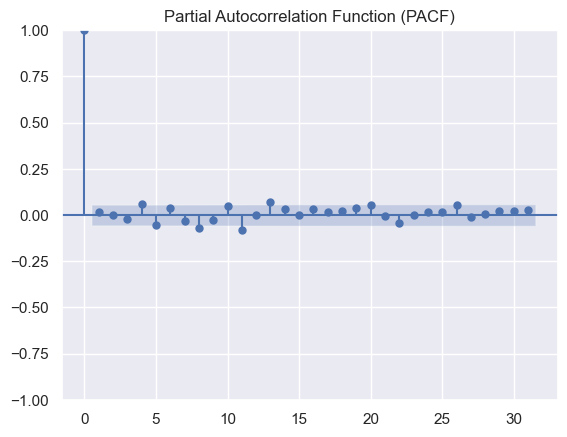

In [62]:
# Create ACF plot
plot_acf(train) 
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

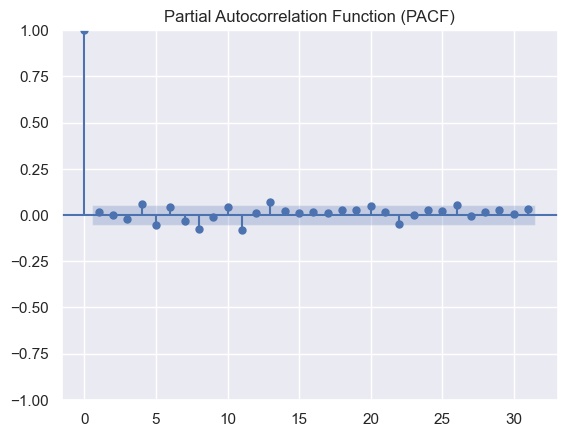

In [63]:
# Create PACF plot
plot_pacf(train)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

### Model Selection

In [64]:


model = sm.tsa.ARIMA(apple_diff, order=(0,1,0))
fit_model = model.fit()

In [65]:
start_index = len(train)
# End predicting at the end of the test data
end_index = len(train) + len(test) - 1


predictions = fit_model.predict(start=start_index, end=end_index)
predictions

date
2014-11-28    1.400002
2014-12-01   -0.070000
2014-12-02   -3.860000
2014-12-03   -0.440003
2014-12-04    1.300003
                ...   
2016-12-23   -0.769997
2016-12-27    0.229996
2016-12-28    0.740005
2016-12-29   -0.500000
2016-12-30   -0.029999
Name: predicted_mean, Length: 527, dtype: float64

In [66]:
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 1761
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -3603.572
Date:                Thu, 28 Sep 2023   AIC                           7209.143
Time:                        02:21:02   BIC                           7214.616
Sample:                             0   HQIC                          7211.166
                               - 1761                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         3.5152      0.069     50.738      0.000       3.379       3.651
===================================================================================
Ljung-Box (L1) (Q):                 401.84   Jarque-Bera (JB):              1099.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.54   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Time to re-transform data back to original scale

In [67]:
pred_model_diff = pd.Series(fit_model.fittedvalues, copy=True)
pred_model_diff.head()

date
2010-01-05    0.000000
2010-01-06    0.052856
2010-01-07   -0.487143
2010-01-08   -0.055714
2010-01-11    0.200001
dtype: float64

In [68]:
pred_model_diff_cumsum = pred_model_diff.cumsum()
pred_model_diff_cumsum.head()

date
2010-01-05    0.000000
2010-01-06    0.052856
2010-01-07   -0.434286
2010-01-08   -0.490000
2010-01-11   -0.289999
dtype: float64

In [69]:
apple_transposed = apple.T
df_final_trans = apple_transposed + pred_model_diff_cumsum
df_final_trans = df_final_trans.T
df_final_trans.fillna(0, inplace=True)
df_final_trans

,close
date,
2010-01-04,0.000000
2010-01-05,30.625713
2010-01-06,30.191427
2010-01-07,29.648571
2010-01-08,29.792858
...,...
2016-12-23,202.237141
2016-12-27,203.207142
2016-12-28,203.447147


In [70]:
apple.tail()

,close
date,
2016-12-23,116.519997
2016-12-27,117.260002
2016-12-28,116.760002
2016-12-29,116.730003
2016-12-30,115.820000


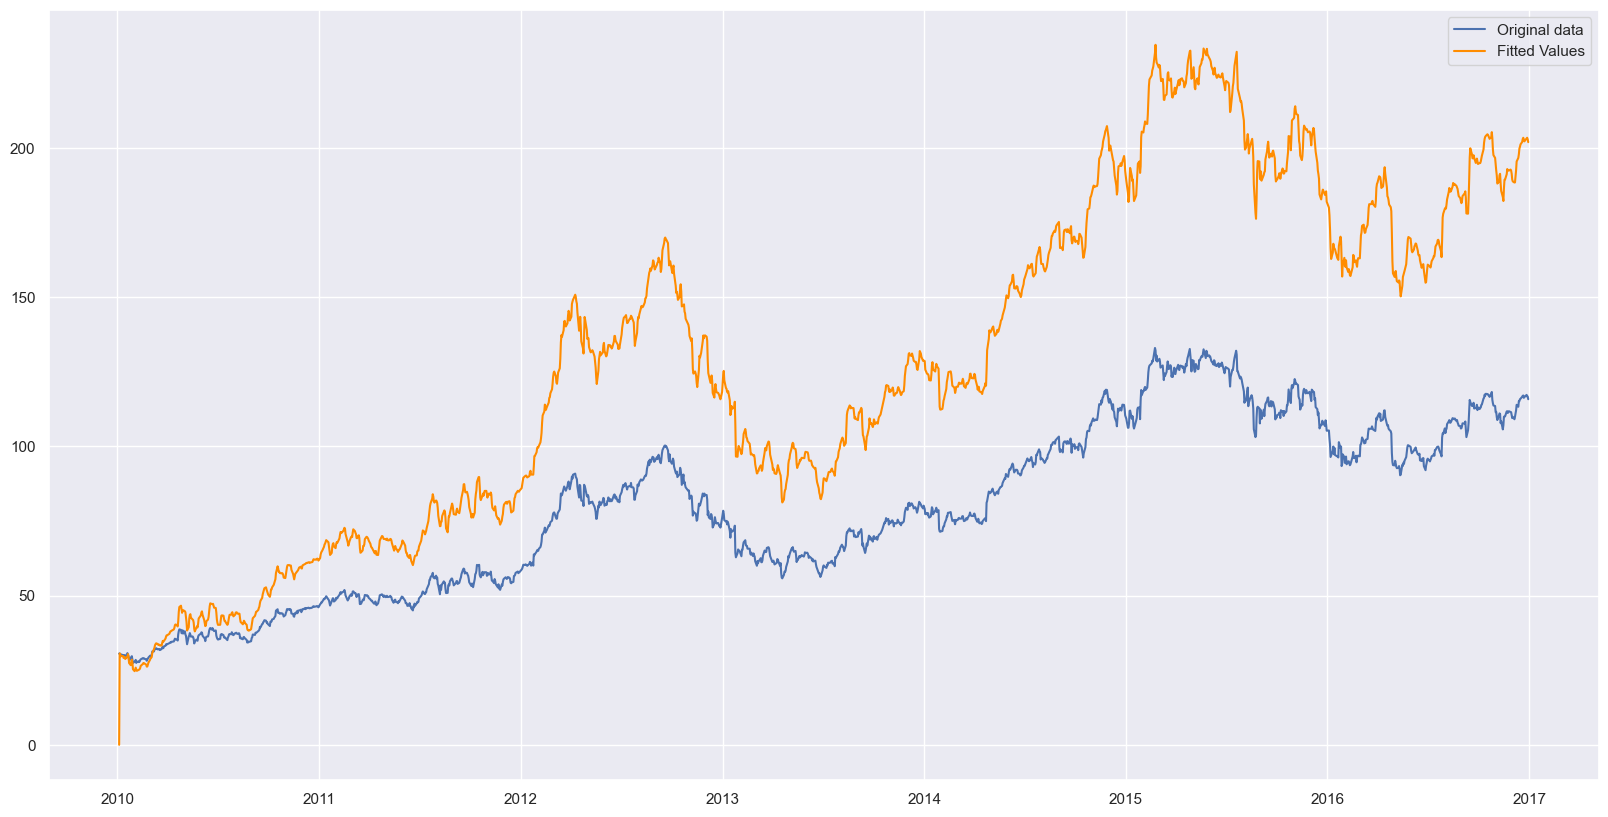

In [111]:
plt.figure(figsize=(20,10))
plt.plot(apple, label='Original data')
plt.plot(df_final_trans, color='darkorange', label='Fitted Values')
plt.legend()

In [72]:
mse = np.sqrt(mean_squared_error(apple, df_final_trans))
mse

56.417518698934224

In [107]:
# Residuals
residuals = fit_model.resid

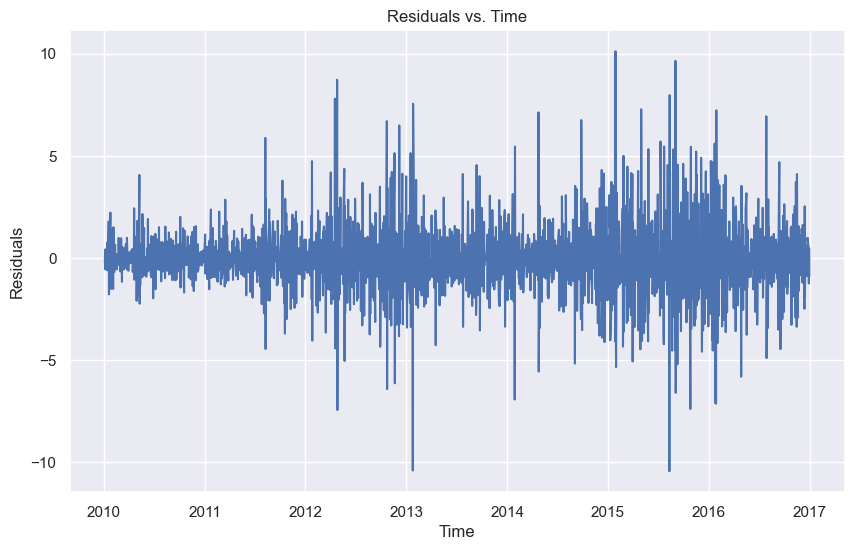

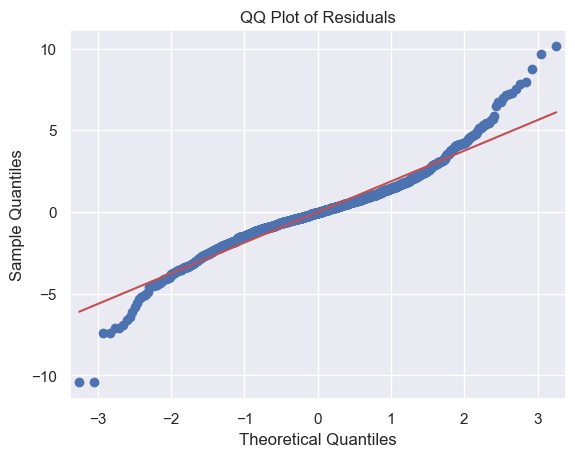

In [106]:
# Residuals vs. Time Plot
plt.figure(figsize=(10, 6))
plt.plot(apple_diff.index, residuals)
plt.title('Residuals vs. Time')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

# QQ Plot (Quantile-Quantile Plot)
sm.qqplot(residuals, line='s')
plt.title('QQ Plot of Residuals')
plt.show()

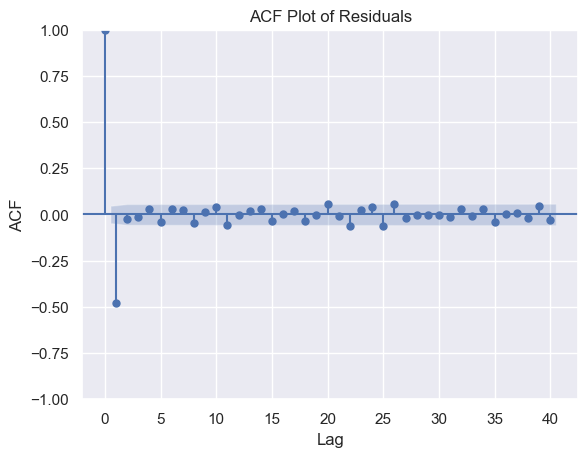

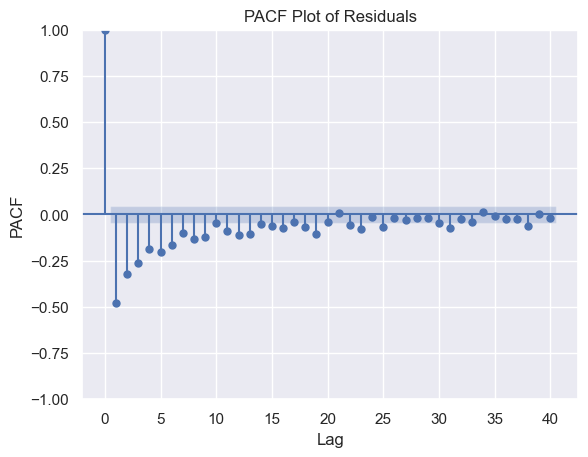

In [75]:
# ACF (Auto-Correlation Function) Plot of Residuals
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.title('ACF Plot of Residuals')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

# PACF (Partial Auto-Correlation Function) Plot of Residuals
sm.graphics.tsa.plot_pacf(residuals, lags=40)
plt.title('PACF Plot of Residuals')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

In [104]:
test_results

,lb_stat,lb_pvalue
1,402.076557,1.944899e-89
2,402.960768,3.149061e-88
3,403.247180,4.383149e-87
4,404.584700,2.842298e-86
5,407.740708,6.365266e-86
6,409.087998,3.107849e-85
7,410.319069,1.459815e-84
8,414.233048,1.687467e-84
9,414.681709,1.007213e-83
10,417.475747,1.789984e-83


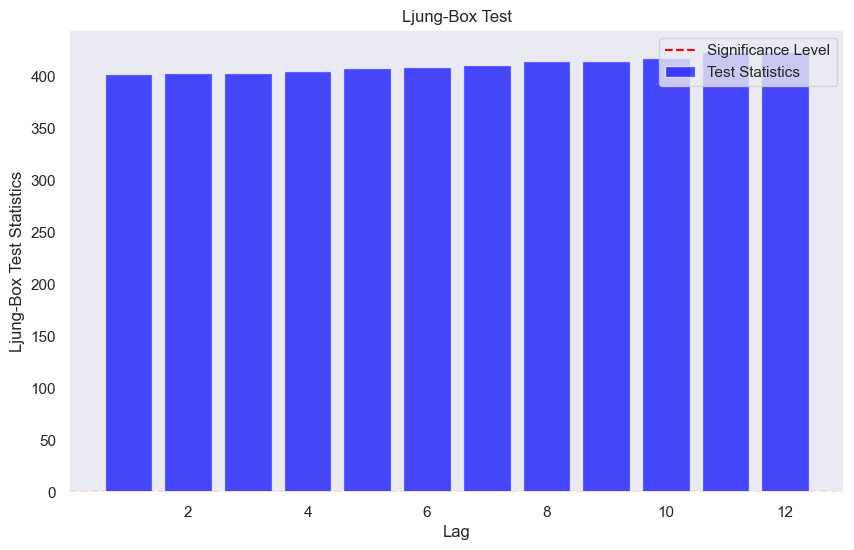

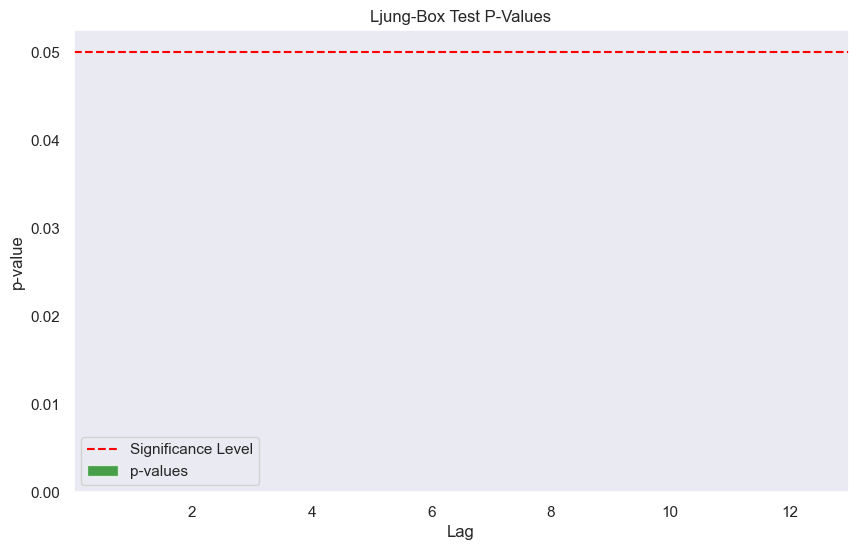

In [110]:

# Set the maximum lag you want to test
lags = 12  # Adjust as needed

# Perform the Ljung-Box test on the residuals
test_results = acorr_ljungbox(residuals, lags=lags)
test_statistics = test_results['lb_stat']  # Access test statistics
p_values = test_results['lb_pvalue']  # Access p-values

# Set the significance level (e.g., 0.05)
significance_level = 0.05

# Create a Ljung-Box plot
plt.figure(figsize=(10, 6))

# Plot the test statistics
plt.bar(range(1, lags + 1), test_statistics, color='blue', alpha=0.7, label='Test Statistics')

# Plot the significance level line
plt.axhline(significance_level, color='red', linestyle='--', label='Significance Level')

plt.xlabel('Lag')
plt.ylabel('Ljung-Box Test Statistics')
plt.title('Ljung-Box Test')
plt.legend()
plt.grid()

# Plot p-values (optional)
plt.figure(figsize=(10, 6))
plt.bar(range(1, lags + 1), p_values, color='green', alpha=0.7, label='p-values')
plt.axhline(significance_level, color='red', linestyle='--', label='Significance Level')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.title('Ljung-Box Test P-Values')
plt.legend()
plt.grid()

plt.show()


# 